In [1]:
# Imports
from utils import read_json_file, write_json_file, read_json_file_or_empty_list
from utils import large_num_short_format
from dotenv import load_dotenv
from typing import  List, Dict
from utils import print_progress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  math

load_dotenv()

True

In [2]:
# Load coins and markets
from download_chart_data import ChartInterval
from download_chart_data import load_chart_by_interval

coins: List[Dict[str, any]] = read_json_file("data/coins.json")
markets: List[Dict[str, any]] = read_json_file("data/markets.json")
print("\nCoins: {}, Markets: {}".format(len(coins), len(markets)))

# Load daily charts and convert them to daily 
charts = load_chart_by_interval(ChartInterval.FULL)
print("\nCharts with price data count: {}".format(len(charts)))


Coins: 10431, Markets: 10431
 Loading chart_full idx: 10424 / 10425, 100.0%       
Charts with price data count: 9887


In [3]:
# Find chart pumps
from download_chart_data import chart_data_to_df
from utils import year_month_str

def is_pump(
    price: float, prev_price: float, pump_ratio: float, volume: float, 
    min_volume: float
) -> bool:
    if math.isnan(prev_price) or math.isnan(price):
        return False
    return price >= prev_price * pump_ratio and volume > min_volume


def pumps_info(
    chart_data: List[Dict[str, any]], pump_ratio: float, min_volume: float
) -> pd.DataFrame:
    df = chart_data_to_df(chart_data)
    df['Ym'] = list(map(lambda x: year_month_str(x), df.index))
    # shift price and add pump bool
    df.insert(1, 'prev_price', df['price'].shift(1))
    df['pump'] = df.apply(
        lambda x: is_pump(x['price'], x['prev_price'], pump_ratio, x['volume'], min_volume),
        axis=1
    )
    # select pump rows
    return df.loc[df['pump'] == True]


pump_ratio = 1.5
min_volume = 500000
chart_pumps_df: Dict[str, pd.DataFrame] = dict()

# for each chart
for idx, key in enumerate(charts):
    chart = charts[key]
    print_progress("Searching for pumps", idx, len(charts), True)
    chart_pumps_df[key] = pumps_info(chart, pump_ratio, min_volume)

 Searching for pumps idx: 9886 / 9887, 100.0%       

In [4]:
# Counting pumps per month
from utils import year_month_keys

keys = year_month_keys(list(range(2017, 2024)), list(range(1, 13)))
df = pd.DataFrame(data={
    'year/month': keys, 
    "pumps": np.zeros(len(keys)), 
    "markets": map(lambda x: "", np.zeros(len(keys)))
})

for idx, key in enumerate(keys):
    for df_key in chart_pumps_df:
        chart_pump_df = chart_pumps_df[df_key]
        pump_cnt = chart_pump_df.loc[chart_pump_df['Ym'] == key].shape[0]
        if pump_cnt > 0:
            df.loc[df['year/month'] == key, 'pumps'] += pump_cnt
            df.loc[df['year/month'] == key, 'markets'] += "{}, ".format(df_key)

    print_progress("Counting for pumps", idx, len(keys), True)
    
chart_pumps_plot_df = df

 Counting for pumps idx: 83 / 84, 98.8%       

   year/month  pumps                                                                          markets legend
70    2022-11  153.0  memecoin, opx-finance, kava-swap, klaycity-orb, dejitaru-tsuka, local-trader...  22-11
71    2022-12  121.0  wallet-defi, tnc-coin, metanept, pixelverse, btrips, ethereumfair, maya-pref...  22-12
72    2023-01  173.0  cope-token, fusotao, morpheus-labs, 1sol, klaycity-orb, frutti-dino, fronk, ...  23-01
73    2023-02  285.0  velo, alexgo, opx-finance, poseidon-2, gamium, rare-fnd, camelot-token, cryp...  23-02
74    2023-03  150.0  zktsunami, fintoken, arb-protocol, gamium, all-in, microchains-gov-token, de...  23-03
75    2023-04  167.0  bob-token, dehealth, nasdex-token, sign, koinos, dgnapp-ai, floki-ceo, maya-...  23-04
76    2023-05  276.0  memecoin, psyop, legends-token, bob-token, pdx-coin, pepesol, guacamole, wed...  23-05
77    2023-06  127.0  psyop, wassie, neon-coin, metanept, bobo-coin, bscex, relevant, biaocoin, ha...  23-06
78    2023-07  164.

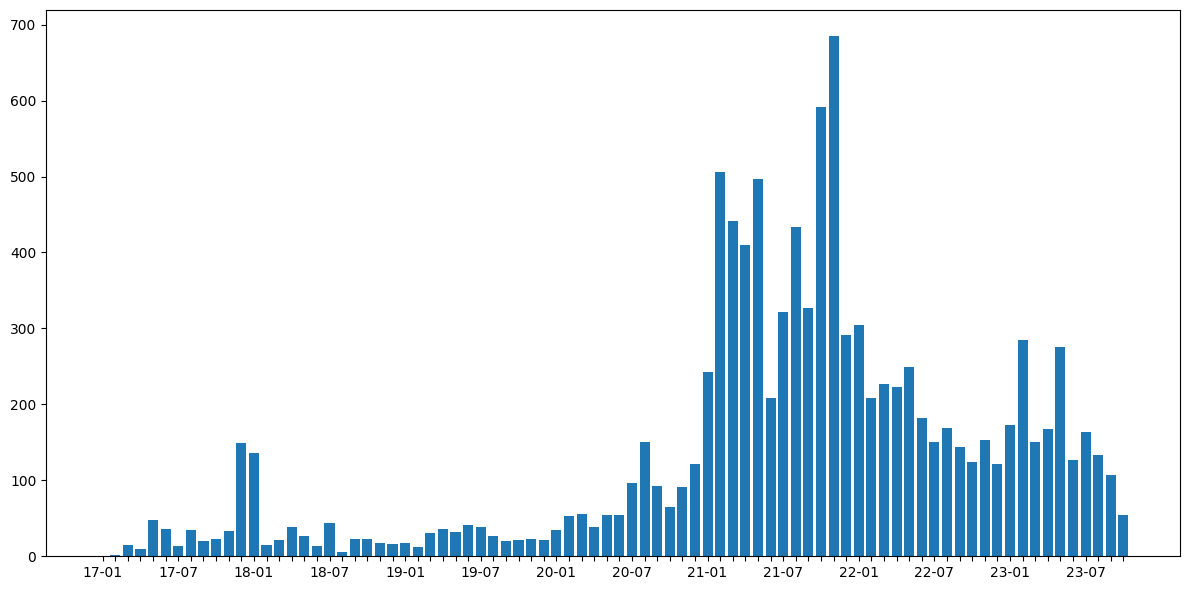

In [5]:
df = chart_pumps_plot_df.copy().head(chart_pumps_plot_df.shape[0] - 2).tail(100)
df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
pd.set_option('display.width', 256)
pd.set_option('display.max_colwidth', 80)
print(df.tail(12))
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['legend'], df['pumps'])

for i, t in enumerate(ax.get_xticklabels()):
    if (i % 6) != 0:
        t.set_visible(False)

plt.tight_layout() 
plt.show()

In [6]:
# Display pump for month
key = '2023-10'
row = chart_pumps_plot_df.loc[chart_pumps_plot_df['year/month'] == key]

markets = row['markets'].values[0].split(', ')[:-1]
for market in markets:
    print(market)

barnbridge
ooki
adappter-token
gold-fever-native-gold
stratis
only-possible-on-ethereum
evadore
swingby
yocoinyoco
roaland-core
decubate
polaris-share
delysium
pepe-token
amber-phantom-butterfly
quiztok
payment-swap-utility-board
octofi
sora
deesse
cryptopawcoin
spx6900
zuzuai
turbo
jesus-coin
pay-coin
blackpearl-chain
long
request-network
equitypay
seiren-games-network
bitica-coin
captain-tsubasa
mind-matrix
basepal
wazirx
gomoney2
lunchdao
spotted-turtle
gameai
apes-go-bananas
big-time
barbiecrashbandicootrfk88
dex-game
dark-queen-duck


In [7]:
# Generate files and charts for variety of configs

def get_chart_pumps_df(
    charts: Dict[str, Dict[str, any]], pump_ratio: float, min_volume: float
) -> Dict[str, pd.DataFrame]:
    chart_pumps_df: Dict[str, pd.DataFrame] = dict()
    for idx, key in enumerate(charts):
        chart = charts[key]
        print_progress("Searching for pumps", idx, len(charts), True)
        chart_pumps_df[key] = pumps_info(chart, pump_ratio, min_volume)
    return chart_pumps_df


def get_chart_pumps_plot_df(
    keys: List[str], chart_pumps_df: Dict[str, pd.DataFrame]
) -> pd.DataFrame:
    df = pd.DataFrame(data={
        'year/month': keys, 
        "pumps": np.zeros(len(keys)), 
        "markets": map(lambda x: "", np.zeros(len(keys)))
    })
    for idx, key in enumerate(keys):
        for df_key in chart_pumps_df:
            chart_pump_df = chart_pumps_df[df_key]
            pump_cnt = chart_pump_df.loc[chart_pump_df['Ym'] == key].shape[0]
            if pump_cnt > 0:
                df.loc[df['year/month'] == key, 'pumps'] += pump_cnt
                df.loc[df['year/month'] == key, 'markets'] += "{}, ".format(df_key)
    
        print_progress("Counting for pumps", idx, len(keys), True)
    return df


def plot_df(chart_pumps_plot_df: pd.DataFrame):
    df = chart_pumps_plot_df.copy().head(chart_pumps_plot_df.shape[0] - 2).tail(100)
    df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
    print(df.tail(12))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(df['legend'], df['pumps'])
    for i, t in enumerate(ax.get_xticklabels()):
        if (i % 6) != 0:
            t.set_visible(False)
    plt.tight_layout() 
    plt.show()


def write_pump_to_file(df: pd.DataFrame, pump_ratio: float, min_volume: float):
    results = read_json_file_or_empty_list('results/chart_info.json')
    info = dict()
    pump_count_for_month = dict()
    pump_coins_for_month = dict()
    for key in df['year/month'].values:
        row = df.loc[df['year/month'] == key]
        pump_count_for_month[key] = row['pumps'].values[0]
        pump_coins_for_month[key] = row['markets'].values[0].split(', ')[:-1]    
    info['pump_ratio'] = pump_ratio 
    info['min_volume'] = min_volume
    info['pump_count_for_month'] = pump_count_for_month
    info['pump_coins_for_month'] = pump_coins_for_month
    results.append(info)
    write_json_file('results/chart_info.json', results)


pd.set_option('display.width', 256)
pd.set_option('display.max_colwidth', 80)

pump_ratios = [1.5, 2.0, 4.0, 8.0]
min_volumes = [100000, 500000, 1000000, 10000000]
keys = year_month_keys(list(range(2017, 2024)), list(range(1, 13)))[-102:-2]
ratio_results = dict()

for pump_ratio in pump_ratios:
    volume_results = dict()
    for min_volume in min_volumes:
        print("Pump ratio: {}, Min Volume: {}".format(pump_ratio, min_volume))
        chart_pumps_df = get_chart_pumps_df(charts, pump_ratio, min_volume)
        chart_pumps_plot_df = get_chart_pumps_plot_df(keys, chart_pumps_df)
        # plot_df(chart_pumps_plot_df)
        write_pump_to_file(chart_pumps_plot_df, pump_ratio, min_volume)
        volume_results[min_volume] = chart_pumps_plot_df
    ratio_results[pump_ratio] = volume_results

pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

Pump ratio: 1.5, Min Volume: 100000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 1.5, Min Volume: 500000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 1.5, Min Volume: 1000000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 1.5, Min Volume: 10000000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 2.0, Min Volume: 100000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 2.0, Min Volume: 500000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 2.0, Min Volume: 1000000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 2.0, Min Volume: 10000000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 4.0, Min Volume: 100000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 4.0, Min Volume: 500000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 4.0, Min Volume: 1000000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ratio: 4.0, Min Volume: 10000000
 Counting for pumps idx: 81 / 82, 98.8%       Pump ra

Pump ratio 1.5x
                  100K        500K         1M        10M
year/month                                              
2023-05     553.000000  276.000000  186.00000  40.000000
2023-06     323.000000  127.000000   88.00000  19.000000
2023-07     380.000000  164.000000  111.00000  24.000000
2023-08     328.000000  134.000000   87.00000  14.000000
2023-09     279.000000  107.000000   65.00000  19.000000
2023-10     144.000000   55.000000   34.00000  12.000000
MEAN        220.036585  132.256098  101.52439  32.195122
MEDIAN      133.000000   60.500000   47.00000  16.500000


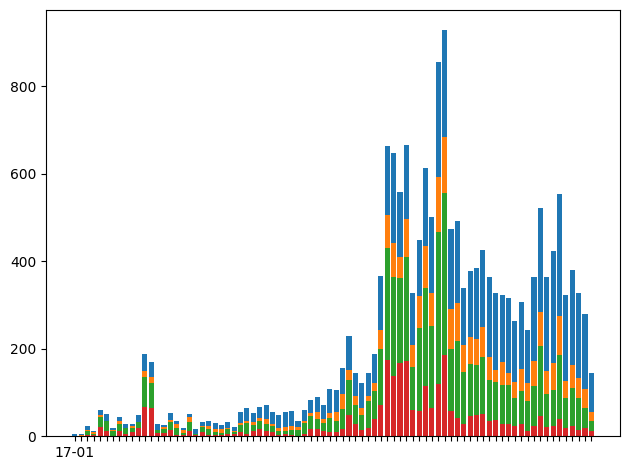

Pump ratio 2.0x
                  100K        500K         1M        10M
year/month                                              
2023-05     219.000000  122.000000  89.000000  16.000000
2023-06     106.000000   38.000000  26.000000   4.000000
2023-07     123.000000   55.000000  37.000000   4.000000
2023-08      97.000000   39.000000  28.000000   2.000000
2023-09     100.000000   34.000000  21.000000   5.000000
2023-10      61.000000   21.000000  13.000000   2.000000
MEAN         71.182927   41.134146  31.268293   9.329268
MEDIAN       44.500000   24.000000  18.000000   5.000000


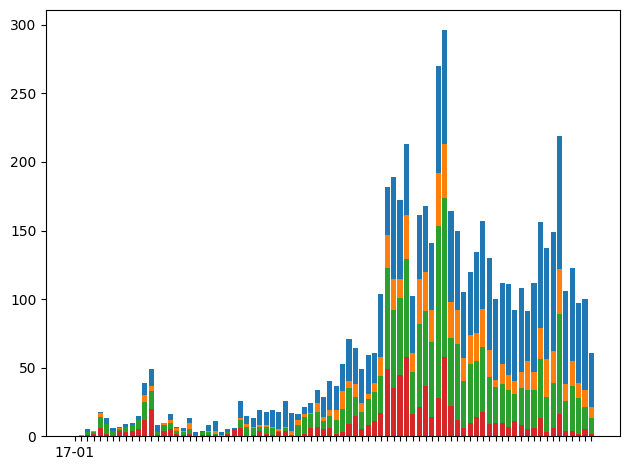

Pump ratio 4.0x
                100K       500K         1M       10M
year/month                                          
2023-05     56.00000  31.000000  23.000000  5.000000
2023-06     31.00000   9.000000   4.000000  1.000000
2023-07     35.00000  14.000000   9.000000  1.000000
2023-08     20.00000   6.000000   3.000000  0.000000
2023-09     31.00000   5.000000   5.000000  1.000000
2023-10     25.00000   8.000000   3.000000  0.000000
MEAN        16.47561   8.682927   5.878049  1.426829
MEDIAN      11.00000   5.500000   3.000000  0.000000


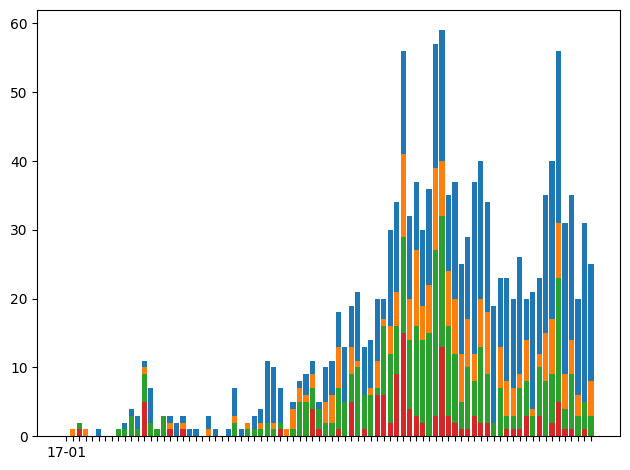

Pump ratio 8.0x
                 100K       500K        1M       10M
year/month                                          
2023-05     25.000000   8.000000  6.000000  2.000000
2023-06     20.000000   6.000000  2.000000  1.000000
2023-07     18.000000  10.000000  6.000000  1.000000
2023-08     10.000000   4.000000  1.000000  0.000000
2023-09     19.000000   5.000000  5.000000  1.000000
2023-10     15.000000   4.000000  2.000000  0.000000
MEAN         8.304878   4.378049  2.743902  0.536585
MEDIAN       6.500000   3.000000  2.000000  0.000000


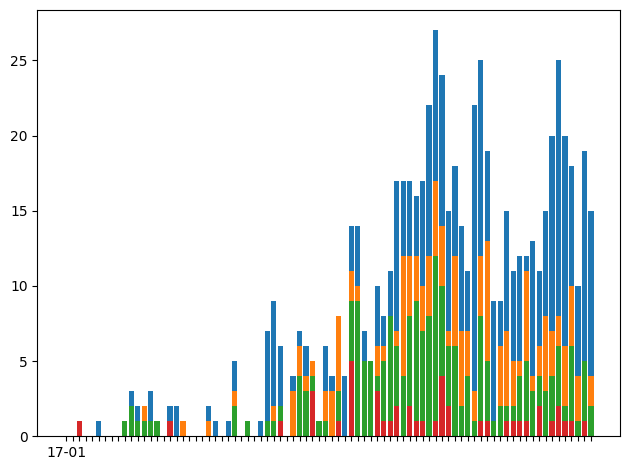

In [13]:
def plot_ratio(ratio: float, volume: Dict[int, pd.DataFrame]):
    fig, ax = plt.subplots()
    for volume_key in volume_results:
        df = volume_results[volume_key]
        df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
        ax.bar(df['legend'], df['pumps'])
        for i, t in enumerate(ax.get_xticklabels()):
            if (i % 6) != 0:
                t.set_visible(False)
    plt.tight_layout() 
    plt.show()


def print_data(ratio: float, volume_results: Dict[int, pd.DataFrame], keep_market: bool = False):
    merged_df = None
    for volume_key in volume_results:
        df = volume_results[volume_key]
        df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
        df = df.set_index('year/month')
        row = pd.DataFrame(data={
            'year/month': ['MEAN', 'MEDIAN'], 
            'pumps': [df.loc[:, 'pumps'].mean(), df.loc[:, 'pumps'].median()]
        })
        row = row.set_index('year/month')
        df = pd.concat([df, row])
        df = df.rename(columns={'pumps': large_num_short_format(volume_key)})
        if keep_market:
            df = df.rename(columns={'markets': large_num_short_format(volume_key)})
            df = df.drop(['legend'], axis=1)
        else:
            df = df.drop(['markets', 'legend'], axis=1)
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.join(df)
    extra = '_mrk' if keep_market else '' 
    merged_df.to_csv('results/chart_ratio_' + str(ratio) + extra + '.csv', index=True)    
    print(merged_df.tail(8))
    
    
for ratio_key in ratio_results:
    print("Pump ratio {}x".format(ratio_key))
    volume_results = ratio_results[ratio_key]
    print_data(ratio_key, volume_results)
    plot_ratio(ratio_key, volume_results)   